In [37]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import pandas as pd
import numpy as np

In [38]:
data = pd.read_csv("framingham_train.csv")
data.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,0,37,Some high school,0,0,0,0,0,0,300,112.0,60.0,23.67,81,75,0
1,1,42,Some college/vocational school,1,10,0,0,0,0,175,116.0,72.5,28.61,63,95,0
2,0,42,Some high school,1,20,0,0,1,0,199,141.0,92.0,43.69,80,60,1
3,0,55,High school/GED,1,5,0,0,0,0,315,123.0,77.5,26.21,75,84,0
4,1,56,High school/GED,1,20,0,0,0,0,270,109.0,75.0,24.58,67,64,0


In [55]:
model = smf.logit("TenYearCHD ~ male +age +education +currentSmoker	+cigsPerDay	\
                    +BPMeds	+prevalentStroke +prevalentHyp +diabetes +totChol \
                    +sysBP +diaBP +BMI+ heartRate +glucose", data = data).fit()

Optimization terminated successfully.
         Current function value: 0.379592
         Iterations 7


In [40]:
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:             TenYearCHD   No. Observations:                 2560
Model:                          Logit   Df Residuals:                     2542
Method:                           MLE   Df Model:                           17
Date:                Mon, 27 Jan 2025   Pseudo R-squ.:                  0.1147
Time:                        21:23:39   Log-Likelihood:                -971.75
converged:                       True   LL-Null:                       -1097.6
Covariance Type:            nonrobust   LLR p-value:                 9.215e-44
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                      -8.2638      0.839     -9.854      0.000      -9.908      -6.620
education[T.High school/GED]    

In [41]:
test = pd.read_csv("framingham_test.csv")

In [42]:
yprob = model.predict(test)
yprob

0       0.069521
1       0.203809
2       0.063341
3       0.055820
4       0.275753
          ...   
1093    0.059773
1094    0.046459
1095    0.171108
1096    0.153250
1097    0.035033
Length: 1098, dtype: float64

In [43]:
yPreds = pd.Series([1 if x > (0.1858) else 0 for x in yprob], index=yprob.index)

In [44]:
np.sum(yPreds)

314

In [45]:
y_true = pd.Series(test["TenYearCHD"])
y_pred = pd.Series(yPreds)

# Calculate True Positives, False Positives, True Negatives, and False Negatives
TP = np.sum((y_true == 1) & (y_pred == 1))  # True Positives
FP = np.sum((y_true == 0) & (y_pred == 1))  # False Positives
TN = np.sum((y_true == 0) & (y_pred == 0))  # True Negatives
FN = np.sum((y_true == 1) & (y_pred == 0))  # False Negatives

# Calculate TPR (True Positive Rate)
tpr = TP / (TP + FN) if (TP + FN) != 0 else 0

# Calculate FPR (False Positive Rate)
fpr = FP / (FP + TN) if (FP + TN) != 0 else 0

# Calculate Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

print(f"True Positive Rate (TPR): {tpr:.2f}")
print(f"False Positive Rate (FPR): {fpr:.2f}")
print(f"Accuracy: {accuracy:.2f}")

True Positive Rate (TPR): 0.57
False Positive Rate (FPR): 0.24
Accuracy: 0.73


In [46]:
costsNaive = [(150000 + 1092500*p) for p in yprob]

In [47]:
np.mean(pd.Series(costsNaive))

314617.341916462

In [48]:
costsPredicted = [(950000* p ) if p<= 0.1858 
                  else (0.15*p)*1100000 + (1-0.15*p)*150000
                  for p in yprob]

In [49]:
np.mean(pd.Series(costsPredicted))

116660.55585210783

In [50]:
zero = np.zeros(1098)

In [51]:
# Calculate True Positives, False Positives, True Negatives, and False Negatives
TP = np.sum((y_true == 1) & (zero == 1))  # True Positives
FP = np.sum((y_true == 0) & (zero == 1))  # False Positives
TN = np.sum((y_true == 0) & (zero == 0))  # True Negatives
FN = np.sum((y_true == 1) & (zero == 0))  # False Negatives

# Calculate TPR (True Positive Rate)
tpr = TP / (TP + FN) if (TP + FN) != 0 else 0

# Calculate FPR (False Positive Rate)
fpr = FP / (FP + TN) if (FP + TN) != 0 else 0

# Calculate Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

print(f"True Positive Rate (TPR): {tpr:.2f}")
print(f"False Positive Rate (FPR): {fpr:.2f}")
print(f"Accuracy: {accuracy:.2f}")

True Positive Rate (TPR): 0.00
False Positive Rate (FPR): 0.00
Accuracy: 0.85


In [52]:
negCosts = [950000*p for p in yprob]

In [53]:
np.mean(pd.Series(negCosts))

143145.51470996696

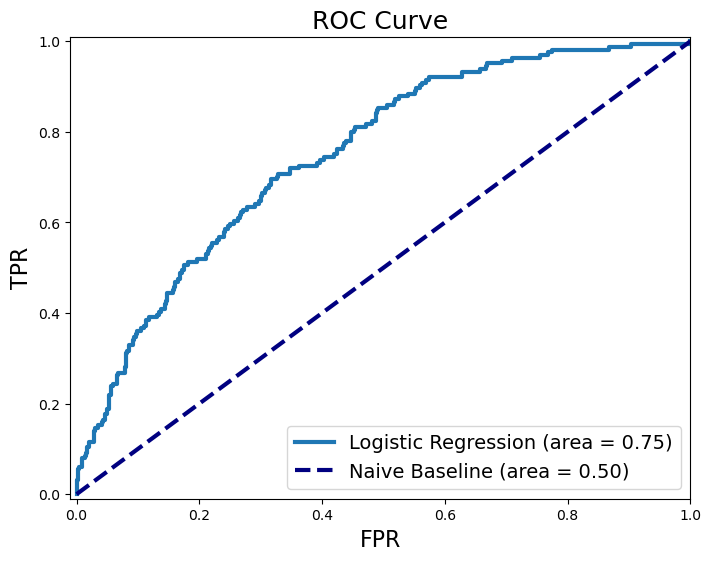

In [54]:
y_train = data["TenYearCHD"]
X_train = data.drop(['TenYearCHD'], axis=1)

y_test = test['TenYearCHD']
X_test = test.drop(['TenYearCHD'], axis=1)

fpr, tpr, _ = roc_curve(y_test, yprob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.title('ROC Curve', fontsize=18)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='Logistic Regression (area = {:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--', label='Naive Baseline (area = 0.50)')
plt.legend(loc='lower right', fontsize=14)
plt.show()